# Unstructured Data Analytics HW2

Name:Aditi Gupta

Andrew ID:argupta

Collaborators (if none, say "none"; do *not* leave this blank): ChatGPT, Class python notebooks, and class notes

Reminder: you should not be sharing code.

## Question 1: Clustering emails using Gaussian Mixture Models [50 pts]

For this problem, we will be analyzing emails taken from the [Enron Email Dataset](https://www.cs.cmu.edu/~enron/). We have already curated the data for you in the `data/enron` directory, with one file per email (so there is no need to redownload the dataset as it is already included in this homework zip archive). The dataset includes a combination of "spam" and "ham" emails. Spam emails are unsolicited messages intended to sell a product or scam users into providing personal information, while ham emails represent everything that is not spam.

The language used in spam emails tends to be considerably different from typical business emails. Most spam filters leverage this difference in word frequencies to detect spam as it arrives and filter it out of email inboxes. We will use Gaussian Mixture Models (GMMs) to cluster the emails and attempt to identify groups of emails which are likely to be spam.

### Part A: Construct a list of processed documents [10 points]

Provided below is a function that returns a document present in a file given a filename. The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words. Using the `make_word_list` function, construct a list of processed documents.

In [39]:
import re
import string
import codecs

def make_word_list(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [40]:
########################################################################
######################### Write your code here #########################
########################################################################
import glob
processed_documents=[]

for file in glob.glob('./data/enron/*.txt'):
    processed_documents.append(make_word_list(file))

### Part B: Construct a document matrix [10 points]

Next, construct a document matrix `X` as a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features for each document. TF-IDF features encode information about the word frequency within a document, weighted by the frequency of the same word for corpus as a whole.

   - Use the `TfidfVectorizer` from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to create the document matrix `X`.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the number of unique words in the vocabulary Hint: Look for the `vocabulary_` attribute in the `TfidfVectorizer` object after fitting the vectorizer to the data set. The vocabulary will also be needed in part (d).

In [41]:
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.8,
                                min_df=50,
                                stop_words='english')
X = vectorizer.fit_transform(processed_documents)
#vectorizer.vocabulary_
print("Number of unique words in the vocabulary:", \
      len(vectorizer.vocabulary_))

Number of unique words in the vocabulary: 1680


### Part C: Perform Clustering [10 points]

Perform clustering on the document matrix `X` using GMMs. 
- Use the `GaussianMixture` module from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to cluster the documents.
- Set the number of clusters (mixture components) to 3.
- Print the number of documents assigned to each cluster.

In [42]:
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

n_clusters=3
gmm = GaussianMixture(n_components=n_clusters, max_iter=100, \
                      n_init=10,random_state=0)

# Convert the sparse matrix X to a dense NumPy array
X_dense = X.toarray()

gmm.fit(X_dense)
gmm_cluster_assignments = gmm.predict(X_dense)

# Print the number of documents assigned to each cluster
for cluster in range(n_clusters):
    num_documents_in_cluster = len(gmm_cluster_assignments\
                                   [gmm_cluster_assignments == cluster])
    print(f"Cluster {cluster}: {num_documents_in_cluster} documents")

Cluster 0: 808 documents
Cluster 1: 3881 documents
Cluster 2: 482 documents


### Part D: Characterize the clusters [10 points]

Now, we will attempt to characterize the clusters based on the frequency of spam-relevant words. 
- Select 3 "spammy" words from the vocabulary that you expect to occur frequently in spam emails and less frequently in normal business emails (e.g., 'click', 'www', 'offer'). Construct a list, `spam_indices`, storing the indices of the spammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Select 3 "hammy" words from the vocabulary you think will occur frequently in business emails and infrequently in spam emails (e.g., 'meeting', 'attached', 'review'). Construct a list, `ham_indices`, storing the indices of the hammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Use the function provided below, `plot_spam_words_by_cluster`, to plot the average TF-IDF features for your selected spammy words and hammy words for each cluster. The function takes the following parameters:
    - `X` is a matrix of TF-IDF features (rows index documents, columns index terms).
    - `predicted` is predicted cluster assignments returned by `GaussianMixture.predict()`
    - `n_clusters` is the number of clusters. This should match the number of clusters from your GMM.
    - `spam_indices` is a list of indices of spammy words in the vocabulary.
    - `ham_indices` is a list of indices of hammy (typical business) words in the vocabulary.

In [43]:
def plot_spam_words_by_cluster(X, predicted, n_clusters, \
                               spam_indices, ham_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_spam = []
    mean_tfidf_ham = []
    for spam in spam_indices:
        mean_tfidf_spam.append([])
    for ham in ham_indices:
        mean_tfidf_ham.append([])
    
    for i in range(n_clusters):
        for j, spam_idx in enumerate(spam_indices):
            mean_tfidf_spam[j].append(X[predicted==i, spam_idx].mean())
        for j, ham_idx in enumerate(ham_indices):
            mean_tfidf_ham[j].append(X[predicted==i, ham_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot spam bars
    for i, val in enumerate(mean_tfidf_spam):
        spam_bar = ax.bar(ind - (len(mean_tfidf_spam)-i-1)*width, \
                          val, width, color='r', bottom=0)

    # Plot ham bars
    for i, val in enumerate(mean_tfidf_ham):
        ham_bar = ax.bar(ind + (len(mean_tfidf_ham)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Spam-Relevant Words')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + \
                           str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((spam_bar[0], ham_bar[0]), ('Spammy words', 'Hammy words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

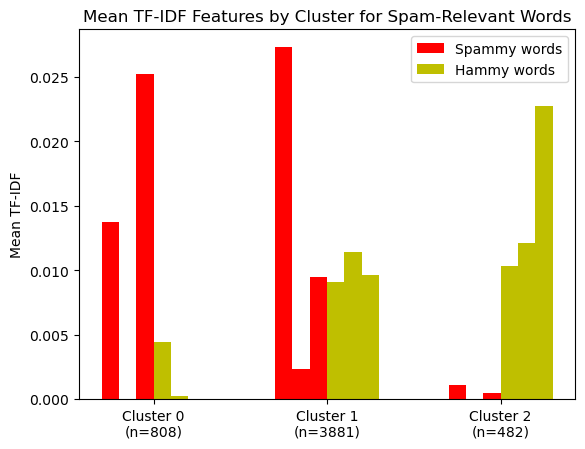

In [44]:
########################################################################
######################### Write your code here #########################
########################################################################
# Select 3 "spammy" words and 3 "hammy" words from the vocabulary
spammy_words = ['click', 'win', 'offer']
hammy_words = ['meeting', 'attached', 'review']

# Create lists to store the indices of selected words in the vocabulary
spam_indices = []
ham_indices = []

# Find the indices of the selected words in the vocabulary
for word in spammy_words:
    if word in vectorizer.vocabulary_:
        spam_indices.append(vectorizer.vocabulary_[word])

for word in hammy_words:
    if word in vectorizer.vocabulary_:
        ham_indices.append(vectorizer.vocabulary_[word])


plot_spam_words_by_cluster(X,gmm_cluster_assignments, \
                           n_clusters, spam_indices, ham_indices)

### Part E: Interpret results [10 points]

From the plot generated in part (d), do any of the clusters correspond to spam emails, based on the frequency of spammy and hammy words? Do any of the clusters appear to correspond to typical business emails (ham)? 

Re-run your analysis with a different choice for the number of clusters in your GMM (e.g., `n_clusters=5` or `n_clusters=2`). How does changing the number of clusters affect your results? Does one choice of `n_clusters` appear better than another for locating clusters of spam emails?

*** WRITE YOUR ANSWER HERE IN TEXT ***

* n_clusters=3
Based on the plot generated in part (d), it can be said that Cluster 0 corresponds to spam emails due to high mean TF-IDF of spammy words. There are some hammy words present but the mean TF-IDF of those words is less. 
And similarly based on high mean TF-IDF of hammy words in Cluster 2, it can be said that Cluster 2 corresponds to typical business emails (ham) though there are some spammy words with less mean TF-IDF.

* n_clusters=2
In this case, it can be said that Cluster 0 corresponds to spam emails due to high mean TF-IDF of spammy words and very low mean TF-IDF of hammy words. 
But nothing can be said about cluster 1. It has a mix of spammy words and hammy words, both having high mean TF-IDF. So, no cluster appears to correspond to typical business emails (ham).

* n_clusters=5
In this case, it can be seen from the graph that Cluster 4 has high mean TF-IDF of spammy words and 0 mean TF-IDF of hammy words. So, it can be said that Cluster 4 definitely corresponds to spam emails.
Cluster 0 and 1 have high mean TF-IDF of spammy words but there are also some hammy words present with low mean TF-IDF. So they can be 
Cluster 2 and 3 have high mean TF-IDF of hammy words but there are also some spammy words present with low mean TF-IDF. 

How does changing the number of clusters affect your results? 
Increasing the number of clusters give a clear distinction between clusters that correspond to typical business emails (ham) and which correspond to spam emails. Whereas with number of clusters =2 the distinction is not very clear.

Does one choice of `n_clusters` appear better than another for locating clusters of spam emails?
Yes, n_clusters=5 is better than n_clusters=3 and n_clusters=2 for locating clusters of spam emails. 

Cluster 0: 915 documents
Cluster 1: 4256 documents


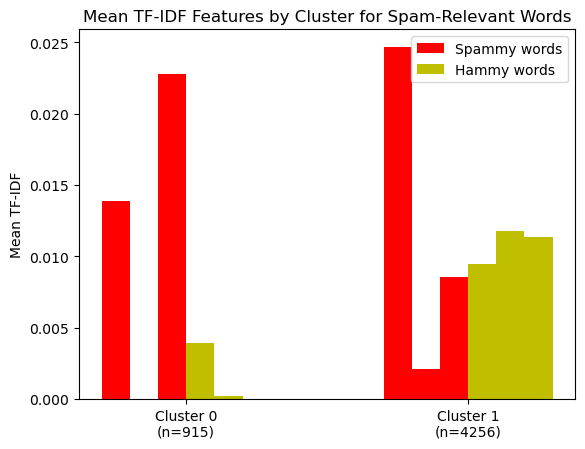

In [45]:
########################################################################
######################### Write your code here #########################
########################################################################
n_clusters=2
gmm = GaussianMixture(n_components=n_clusters, max_iter=100, n_init=10,\
                      random_state=0)

# Convert the sparse matrix X to a dense NumPy array
X_dense = X.toarray()

gmm.fit(X_dense)
gmm_cluster_assignments = gmm.predict(X_dense)

# Print the number of documents assigned to each cluster
for cluster in range(n_clusters):
    num_documents_in_cluster = len(gmm_cluster_assignments\
                                   [gmm_cluster_assignments == cluster])
    print(f"Cluster {cluster}: {num_documents_in_cluster} documents")

plot_spam_words_by_cluster(X,gmm_cluster_assignments, \
                           n_clusters, spam_indices, ham_indices)


Cluster 0: 581 documents
Cluster 1: 2890 documents
Cluster 2: 324 documents
Cluster 3: 1111 documents
Cluster 4: 265 documents


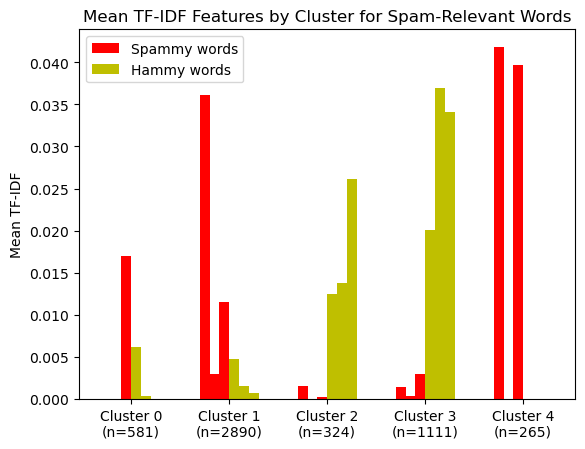

In [46]:
########################################################################
######################### Write your code here #########################
########################################################################
n_clusters=5
gmm = GaussianMixture(n_components=n_clusters, max_iter=100, \
                      n_init=10,random_state=0)

# Convert the sparse matrix X to a dense NumPy array
X_dense = X.toarray()

gmm.fit(X_dense)
gmm_cluster_assignments = gmm.predict(X_dense)

# Print the number of documents assigned to each cluster
for cluster in range(n_clusters):
    num_documents_in_cluster = len(gmm_cluster_assignments\
                                   [gmm_cluster_assignments == cluster])
    print(f"Cluster {cluster}: {num_documents_in_cluster} documents")

plot_spam_words_by_cluster(X,gmm_cluster_assignments, \
                           n_clusters, spam_indices, ham_indices)

## Question 2: Latent "Purposes" in Mobile Apps [45 points]


Think of Android applications as "documents", where "words" are the "permissions" that each app requests. Each app has a set of latent "purposes" (topics); a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength.

Can we uncover these purposes from a dataset of Android applications and the permissions they request?

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Part A: Load the data [0 points]

The [dataset](http://www.mariofrank.net/andrApps/) contains ~180,000 applications from the Android app store, including each app's name, description and permissions requested. For more about Android app permissions, see [this report](http://www.pewinternet.org/2015/11/10/an-analysis-of-android-app-permissions/).

   * Download the data and unzip it into the same folder as this notebook.
   * Rename the CSV file to "android.csv".
   * Run the cells below to load the data into the notebook.

This may take up ~2GB of RAM.

In [48]:
df = pd.read_csv("android.csv", sep=",",  thousands=",")

In [49]:
df["Number of ratings"] = df["Number of ratings"].astype(int) 
# fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

In [50]:
df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Part B: Convert each app into a "document" [0 points]

The code below does the following:

   * Filter out all the columns except the permission columns.
   * Convert this dataframe into a numpy matrix.

There are thus 180295 apps (documents) and 173 permissions (words).

   - `X` is the "document" or "word-frequency" matrix.
   - `permission_columns` contains the words ordered by their column index in X.
   - `app_names` contains the application names ordered by their row index in X.
   - `app_ratings` contains the *number* of application ratings (not the ratings themselves).

In [51]:
permission_columns = list(df.columns[10:])
app_names = list(df["App"])
app_ratings = np.array(df["Number of ratings"])
df_perms = df[permission_columns]
X = df_perms.values
#del df # uncomment to free up RAM
#del df_perms # uncomment to free up RAM

### Part C: Downweight "stopwords" [2.5 points]

There are some permissions requested by almost all applications (like "INTERNET"), they are similar to stop-words ("the", "and", etc.) in natural language. We can downweight them by TF-IDF normalization.

   * Use the `TfidfTransformer` class in `scikit-learn` to transform X.

In [52]:
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.feature_extraction.text import TfidfTransformer
tfidf=TfidfTransformer()
X_tfidf = tfidf.fit_transform(X)

### Part D: Discover 10 "topics" [2.5 points]

   * Use the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the data.
   * Use 10 max iterations, set `n_jobs=-1` to use all cores on your machine (if it helps).
   * Feel free to understand and play around with other parameters.
   * This may take around 3 minutes to run.

In [53]:
%%time
########################################################################
######################### Write your code here #########################
########################################################################
num_topics = 10

from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=num_topics,\
                                max_iter=10,n_jobs=-1,random_state=0)
lda.fit(X_tfidf)

CPU times: user 2.28 s, sys: 281 ms, total: 2.56 s
Wall time: 13.6 s


LatentDirichletAllocation(n_jobs=-1, random_state=0)

Now each app can be viewed as a distribution over these 10 topics, and each topic is a distribution over all the permissions in the data.

### Part E: List the top 10 "words" in each topic [15 points]

Do any of the topics correspond to meaningful app "purposes"? List the ones you find meaningful below:

   * Topic #i: "your interpretation"

In [61]:
########################################################################
######################### Write your code here #########################
########################################################################
num_top_words = 10  # Number of top words to list for each topic

topic_word_distributions = lda.components_

for i, topic_dist in enumerate(topic_word_distributions):
    top_words_indices = topic_dist.argsort()[::-1][:num_top_words]
    top_words = [permission_columns[idx] for idx in \
                 top_words_indices]
    
    # Print the topic number and its top words on separate lines
    print(f"Topic #{i}:")
    for word in top_words:
        print(word)
    print() 

Topic #0:
Your location : coarse (network-based) location (D)
Your location : fine (GPS) location (D)
Network communication : full Internet access (D)
Network communication : view network state (S)
Phone calls : read phone state and identity (D)
Storage : modify/delete USB storage contents modify/delete SD card contents (D)
Services that cost you money : directly call phone numbers (D)
Your personal information : read sensitive log data (D)
Network communication : view Wi-Fi state (S)
Default : access checkin properties (S)

Topic #1:
Hardware controls : control vibrator (S)
Network communication : full Internet access (D)
Network communication : view network state (S)
Storage : modify/delete USB storage contents modify/delete SD card contents (D)
System tools : disable keylock (D)
Phone calls : read phone state and identity (D)
System tools : prevent device from sleeping (D)
Hardware controls : change your audio settings (D)
Default : modify battery statistics (S)
System tools : modif

*** WRITE YOUR ANSWER HERE IN TEXT ***

Here are interpretations for each of the 10 topics based on the top 10 permissions (words) in each topic:

Topic #0: Location and Network Access

1. This topic appears to be related to apps that require location access (both coarse and fine), full internet access, phone state and identity access, storage modification, and the ability to make phone calls and access sensitive log data. 
2. Apps in this category might involve functionalities related to location-based services, network communication, data storage, and possibly services that involve phone call functionality.

Topic #1: Device Control and Connectivity

1. This topic seems to be related to apps that have permissions to control hardware features such as the vibrator and audio settings, access the internet (full internet access), view network state, modify storage (USB and SD card contents), and interact with system tools.
2. Apps in this category might involve functionalities related to controlling and customizing device hardware, managing network connectivity, and modifying system settings.
3. The permissions related to phone calls and reading phone state and identity may indicate that these apps may have some call-related or device identification features.
4. The presence of permissions related to preventing the device from sleeping suggests that these apps may involve tasks that require the device to remain active.

Topic #2: Account Management and Communication

1. This topic appears to be related to apps that involve network communication with full internet access and the ability to view network state.
2. It includes permissions related to managing user accounts, particularly Google Finance accounts, and accessing personal information such as reading contact data.
3. Apps in this category may also have permissions to modify global system settings and use authentication credentials of user accounts.
4. The presence of permissions related to sending SMS messages and receiving SMS suggests that these apps may be involved in communication and possibly financial or account-related transactions.

Topic #3: Account Management and App Control

1. This topic relates to apps focused on account management, including discovering known accounts and using authentication credentials.
2. These apps may also have permissions for installing other applications and managing user accounts.
3. They have broader system-level access with permissions for storage modification, network communication, and system control.
4. Access to phone state and identity suggests they may have some phone-related features.

Topic #4: System Control and Connectivity

1. This topic is related to apps focused on controlling the device and ensuring network connectivity.
2. Permissions include preventing the device from sleeping, full internet access, and starting at boot.
3. Apps may also have control over storage, phone state, hardware features (vibrator), and UI settings, including wallpaper management.

Topic #5: Multimedia and Storage

1. This topic relates to apps that focus on multimedia functions, storage modification, and network connectivity.
2. Permissions include modifying storage (USB and SD card contents), taking pictures and videos, and accessing phone state and identity.
3. Apps may also interact with system tools for setting wallpapers, managing filesystems, and handling instant messaging.

Topic #6: Multimedia, Location, and Hardware Control

1. This topic is related to apps that primarily focus on multimedia functions, location access, and hardware control.
2. Permissions include taking pictures and videos, recording audio, modifying storage, and accessing location data (fine and coarse).
3. Apps may also have full internet access, control hardware features like the vibrator, and interact with phone state and identity.
4. Access to extra location provider commands suggests advanced location-related functionality.

Topic #7: Network and Connectivity

1. This topic is related to apps that focus on network communication and connectivity management.
2. Permissions include viewing Wi-Fi and network state, full internet access, and creating Bluetooth connections.
3. Apps may also interact with phone state and identity and have control over storage.
4. System-level tools for changing Wi-Fi and network settings, as well as Bluetooth administration and Wi-Fi multicast reception, indicate connectivity management.

Topic #8: Device Information and Connectivity

1. This topic is related to apps that focus on retrieving device information and connectivity.
2. Permissions include accessing running applications, phone state and identity, directly calling phone numbers, and full internet access.
3. Apps may also interact with network state, receive data from the internet, modify storage, and control system functions.
4. Access to hardware controls like the vibrator and fine GPS location indicates potential device control and location-based features.

Topic #9: Personal Information and Communication

1. This topic is related to apps that focus on accessing personal information, communication, and system control.
2. Permissions include reading and writing contact data, sending SMS messages, receiving SMS messages, and intercepting outgoing calls.
3. Apps may also have full internet access, read phone state and identity, and modify global system settings.
4. The ability to automatically start at boot suggests system-level control.

### Part F: For each topic, list the top 3 apps with at least 100000 ratings having the highest probability assigned to that topic [15 points]

   - This further helps us understand what the topics actually mean.
   - However, the data is noisy and this exercise may result in listing a bunch of obscure apps.
   - Hence, filtering out all apps with less than 100000 ratings may help.

In [56]:
########################################################################
######################### Write your code here #########################
########################################################################

# Create an empty dictionary to store the top apps for each topic
top_apps_by_topic = {i: [] for i in range(num_topics)}

topic_probabilities = lda.transform(X_tfidf)

for i in range(num_topics):
    top_apps_indices = np.where(app_ratings >= 100000)[0]
    top_apps_indices = np.argsort(topic_probabilities[:, i])[::-1]
    top_apps_indices = [idx for idx in top_apps_indices\
                        if idx in top_apps_indices][:3]  
    
    for app_idx in top_apps_indices:
        app_name = app_names[app_idx]
        app_probability = topic_probabilities[app_idx, i]
        top_apps_by_topic[i].append((app_name, app_probability))

# Print the top 3 apps for each topic
for i in range(num_topics):
    print(f"Topic #{i}:")
    for app_name, app_probability in top_apps_by_topic[i]:
        print(f"App: {app_name}, Probability: {app_probability:.4f}")
    print()

Topic #0:
App: Road Fighter, Probability: 0.7619
App: family doctor, Probability: 0.7619
App: Sex and love, Probability: 0.7619

Topic #1:
App: Chaos.Theory, Probability: 0.7613
App: Punk Ball, Probability: 0.7613
App: Cross Fingers, Probability: 0.7613

Topic #2:
App: Custom Action Tap, Probability: 0.6247
App: BERONCHO CHAMELEON, Probability: 0.6247
App: The Sun Sets At Dawn Movie, Probability: 0.6247

Topic #3:
App: CC switch widget, Probability: 0.8650
App: Sprite Backup, Probability: 0.8639
App: Optimize Tool Box Lite version, Probability: 0.8614

Topic #4:
App: Manchester City Fan Talk Live, Probability: 0.7678
App: Wigan Athletic Fan Talk Live, Probability: 0.7678
App: Wigan Athletic Fan Club Live, Probability: 0.7678

Topic #5:
App: Kabegami.com, Probability: 0.7186
App: butterfly wallpapers, Probability: 0.7081
App: droiDoodle, Probability: 0.7081

Topic #6:
App: Corona Beach Break, Probability: 0.8170
App: Talking Pong Pig Free, Probability: 0.8158
App: app???lab, Probability

### Part G: Visualize the document-topic proportion matrix in 2-D using t-SNE [10 points]

Does our reduced dimensional space contain any structure? Visualize the documents (in the topic-space) using t-SNE.

   * Use `TSNE` from `scikit-learn`.
   * Set the angle to 0.99 and init to 'PCA'. Pick any learning rate that gives you a visually pleasing result.
   * You may `fit` TSNE to a sample of the data (>1000 documents) instead of the full data.
   * Remember to call `fit_transform` to obtain your 2-D data.
   * Plot the t-SNE dimensions as a scatterplot.
   * Color each point based on its most probable topic. Make sure you include a legend (10 colors).
   
Clusters in the t-SNE plot indicate groups of apps that have similar topics.

CPU times: user 39min 46s, sys: 11min 23s, total: 51min 10s
Wall time: 7min 3s


(-62.70496139526367, 50.8590446472168, -59.58664722442627, 58.98755283355713)

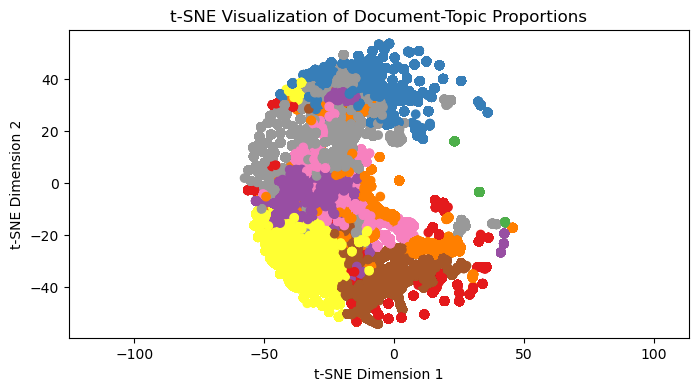

In [62]:
%%time
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=num_topics, n_init=1000, random_state=0)
kmeans.fit(topic_probabilities)
kmeans_cluster_assignments = kmeans.predict(topic_probabilities)

tsne = TSNE(n_components=2, random_state=0,  angle=0.99, \
            init='pca',learning_rate=200) 
X_tsne2d = tsne.fit_transform(topic_probabilities)

plt.figure(figsize=(8, 4))
plt.scatter(X_tsne2d[:, 0], X_tsne2d[:, 1],\
            c=kmeans_cluster_assignments, cmap='Set1')
plt.title("t-SNE Visualization of Document-Topic Proportions")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.axis('equal')

## Question 3: Questionnaire [5 points]

Please answer this survey after you have done this homework: https://forms.gle/8i5htD6oXMr1nK958